In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split
df = pd.read_csv('classData.csv')
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)  # 70% train, 30% test

train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Identify target and feature columns
target_cols = df.columns[:4].tolist()     # first 4 columns are outputs
feature_cols = df.columns[4:10].tolist()  # next 6 columns are features

# Step 2: Identify "no fault" rows (where all 4 output bits are 0)
no_fault_mask = (df[target_cols] == 0).all(axis=1)
no_fault_df = df[no_fault_mask]
other_df = df[~no_fault_mask]

# Step 3: Randomly keep 50% of the "no fault" rows
no_fault_sampled = no_fault_df.sample(frac=0.5, random_state=42)

# Step 4: Combine with the rest of the data
balanced_df = pd.concat([no_fault_sampled, other_df], ignore_index=True)

# Optional: Shuffle the dataset after sampling
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Normalize feature columns (StandardScaler handles +/- values)
scaler = StandardScaler()
balanced_df[feature_cols] = scaler.fit_transform(balanced_df[feature_cols])

# ✅ Final balanced and normalized dataset
print("✔️ Dataset balanced and normalized. Shape:", balanced_df.shape)
balanced_df.to_csv("balanced_normalized_dataset.csv", index=False)

✔️ Dataset balanced and normalized. Shape: (6678, 10)


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# fixing target and inputs
target_cols = train_df.columns[:4].tolist()
feature_cols = train_df.columns[4:10].tolist()

X_train = train_df[feature_cols]
y_train = train_df[target_cols]
X_test = test_df[feature_cols]
y_test = test_df[target_cols]

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'DecisionTree': DecisionTreeClassifier(),
    'NaiveBayes': GaussianNB(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True),
    'ANN_MLP': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

def evaluate_model(name, model):
    clf = MultiOutputClassifier(model)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Calculate average F1 score across all labels
    avg_f1 = f1_score(y_test, y_pred, average='macro')
    avg_acc = accuracy_score(y_test, y_pred)

    print(f"{name:20s} | Accuracy: {avg_acc:.4f} | Avg F1: {avg_f1:.4f}")
    return name, avg_acc, avg_f1

# Run comparisons
results = []
print("Model Comparison:")
print("-" * 50)
for name, model in models.items():
    results.append(evaluate_model(name, model))


Model Comparison:
--------------------------------------------------
LogisticRegression   | Accuracy: 0.1507 | Avg F1: 0.6800
RandomForest         | Accuracy: 0.8423 | Avg F1: 0.9603
GradientBoosting     | Accuracy: 0.8149 | Avg F1: 0.9524
DecisionTree         | Accuracy: 0.8453 | Avg F1: 0.9611
NaiveBayes           | Accuracy: 0.6582 | Avg F1: 0.9104
KNN                  | Accuracy: 0.7745 | Avg F1: 0.9428
SVC                  | Accuracy: 0.7595 | Avg F1: 0.9366
ANN_MLP              | Accuracy: 0.8323 | Avg F1: 0.9528


In [ ]:
import numpy as np
import pandas as pd
from sklearn.multioutput import MultiOutputClassifier
from sklearn.tree import DecisionTreeClassifier

# Train Decision Tree model
dt_model = MultiOutputClassifier(DecisionTreeClassifier(random_state=42))
dt_model.fit(train_df[feature_cols], train_df[target_cols])

# Predict on test inputs
y_pred = dt_model.predict(test_df[feature_cols])
y_pred_df = pd.DataFrame(y_pred, columns=target_cols, index=test_df.index)

def map_fault_label(bits):
    bits_str = ''.join(bits.astype(str))
    if bits_str == '0000':
        return 'no fault'
    elif bits_str == '1001':
        return 'LG fault'
    elif bits_str in ['1011', '1110']:
        return 'LLG fault'
    elif bits_str in ['0110', '0011','0101']:
        return 'LL fault'
    elif bits_str == '1111':
        return 'LLLG fault'
    elif bits_str == '0111':
        return 'LLL fault'
    else:
        return 'Unknown fault'

test_df['Actual_Fault'] = test_df[target_cols].apply(map_fault_label, axis=1)
test_df['Predicted_Fault'] = y_pred_df.apply(map_fault_label, axis=1)

# Save updated dataset to CSV
test_df.to_csv('test_df_with_fault_predictions.csv', index=False)


Saved updated dataset with predictions to 'test_df_with_fault_predictions.csv'


In [6]:
# Add L fault pattern here (adjust if needed)
def map_fault_label_extended(bits):
    bits_str = ''.join(bits.astype(str))
    if bits_str == '0000':
        return 'no fault'
    elif bits_str == '1001':
        return 'LG fault'
    elif bits_str in ['1011', '1110']:
        return 'LLG fault'
    elif bits_str in ['0110', '0011','0101']:
        return 'LL fault'
    elif bits_str == '1111':
        return 'LLLG fault'
    elif bits_str == '0111':
        return 'LLL fault'
    elif bits_str in ['0001', '0010','0100']:
        return 'LLL fault'
    else:
        return 'Unknown fault'

# Assuming you have Actual_Fault and Predicted_Fault columns already
# Count occurrences in Actual_Fault column
actual_counts = test_df['Actual_Fault'].value_counts()
predicted_counts = test_df['Predicted_Fault'].value_counts()

print("Actual Fault Counts:\n", actual_counts)
print("\nPredicted Fault Counts:\n", predicted_counts)


Actual Fault Counts:
 no fault      716
LG fault      358
LLG fault     353
LLLG fault    337
LL fault      304
LLL fault     291
Name: Actual_Fault, dtype: int64

Predicted Fault Counts:
 no fault         714
LG fault         362
LLG fault        347
LLL fault        327
LL fault         302
LLLG fault       301
Unknown fault      6
Name: Predicted_Fault, dtype: int64


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

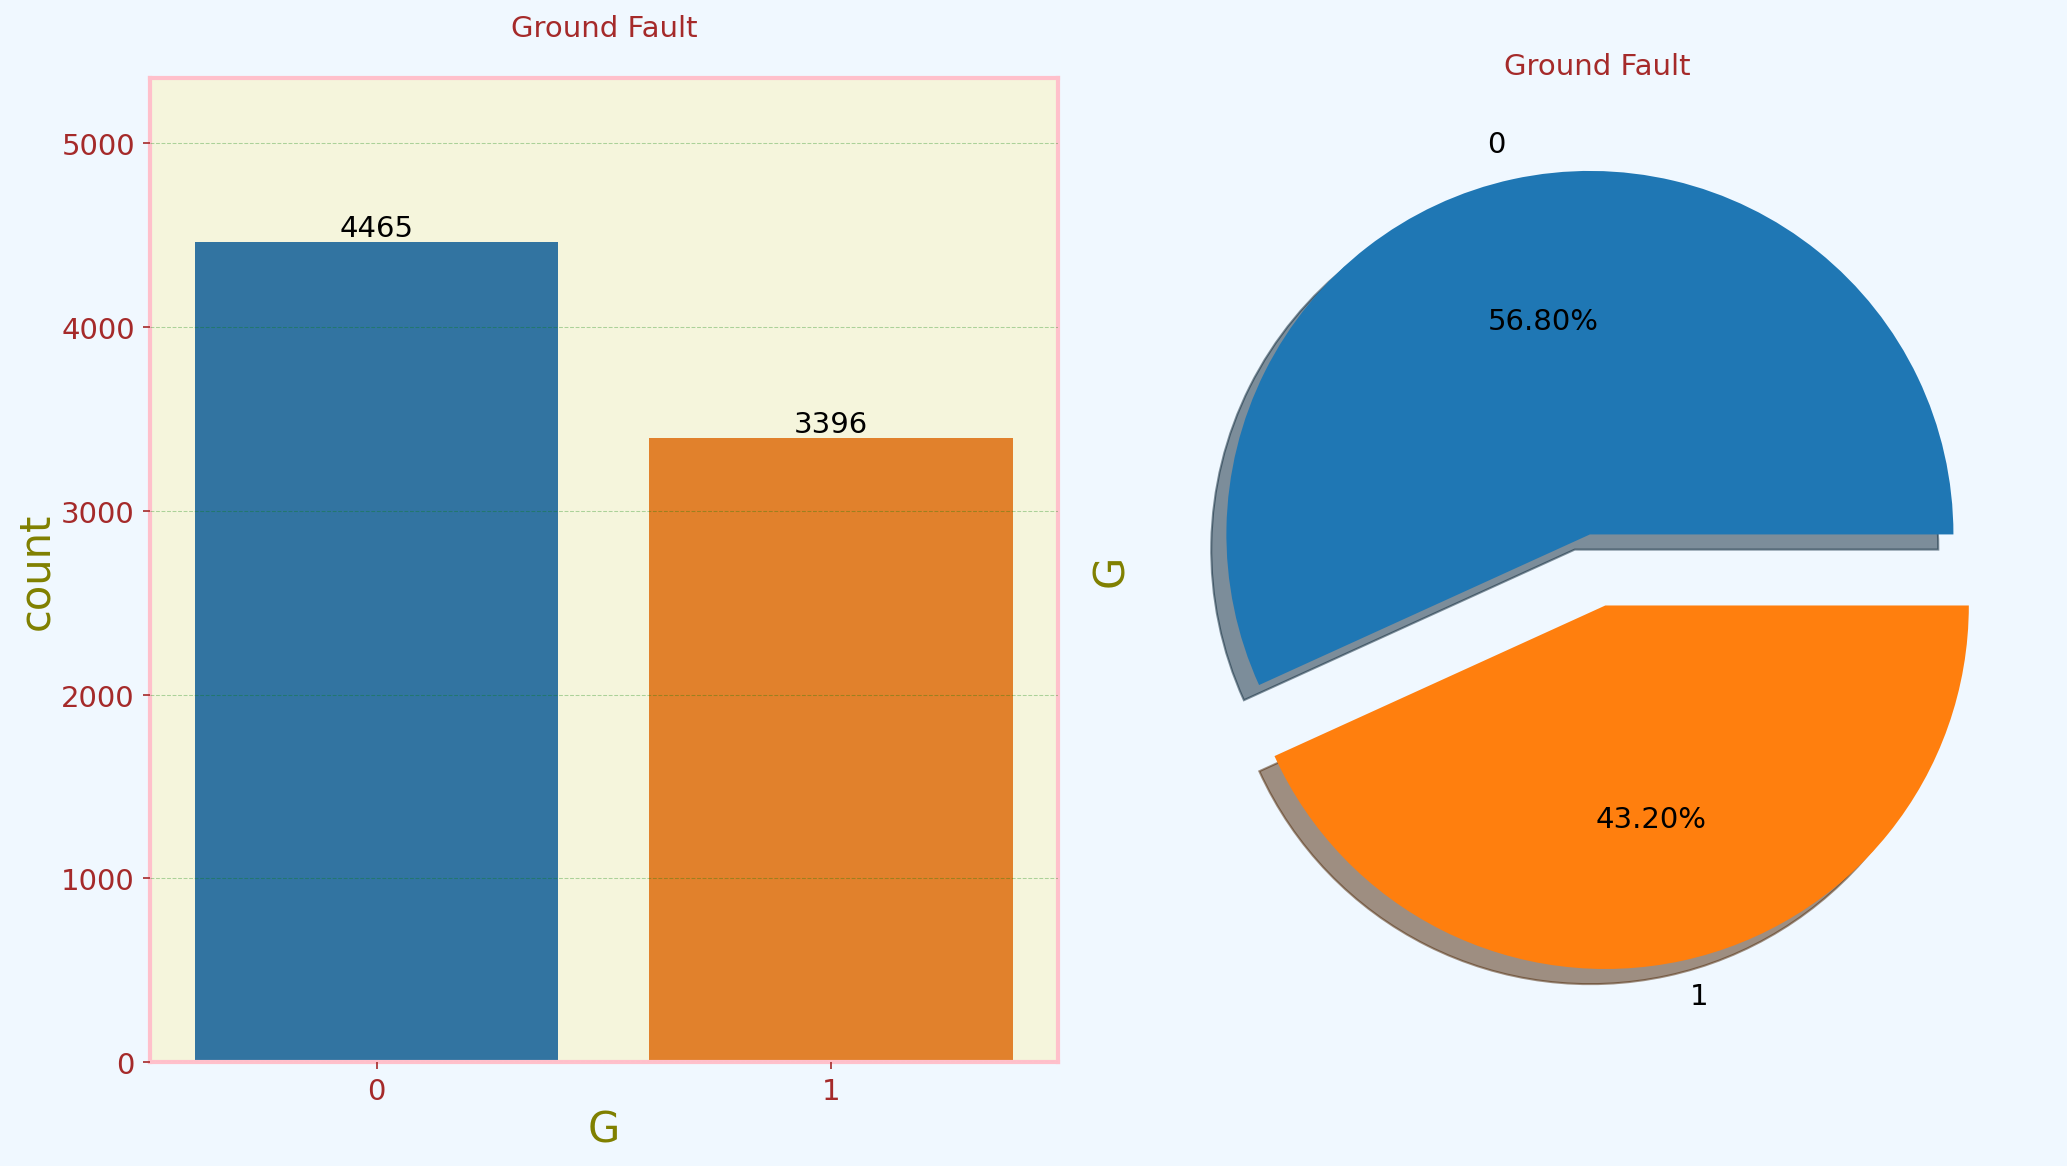

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline 
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='G', data=df)
ax.bar_label(ax.containers[0])
plt.title("Ground Fault", fontsize=20,color = 'Brown',font='Lucida Calligraphy',pad=20)

ax =plt.subplot(1,2,2)
ax=df['G'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Ground Fault", fontsize = 20,color='Brown',font='Lucida Calligraphy',pad=20);

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

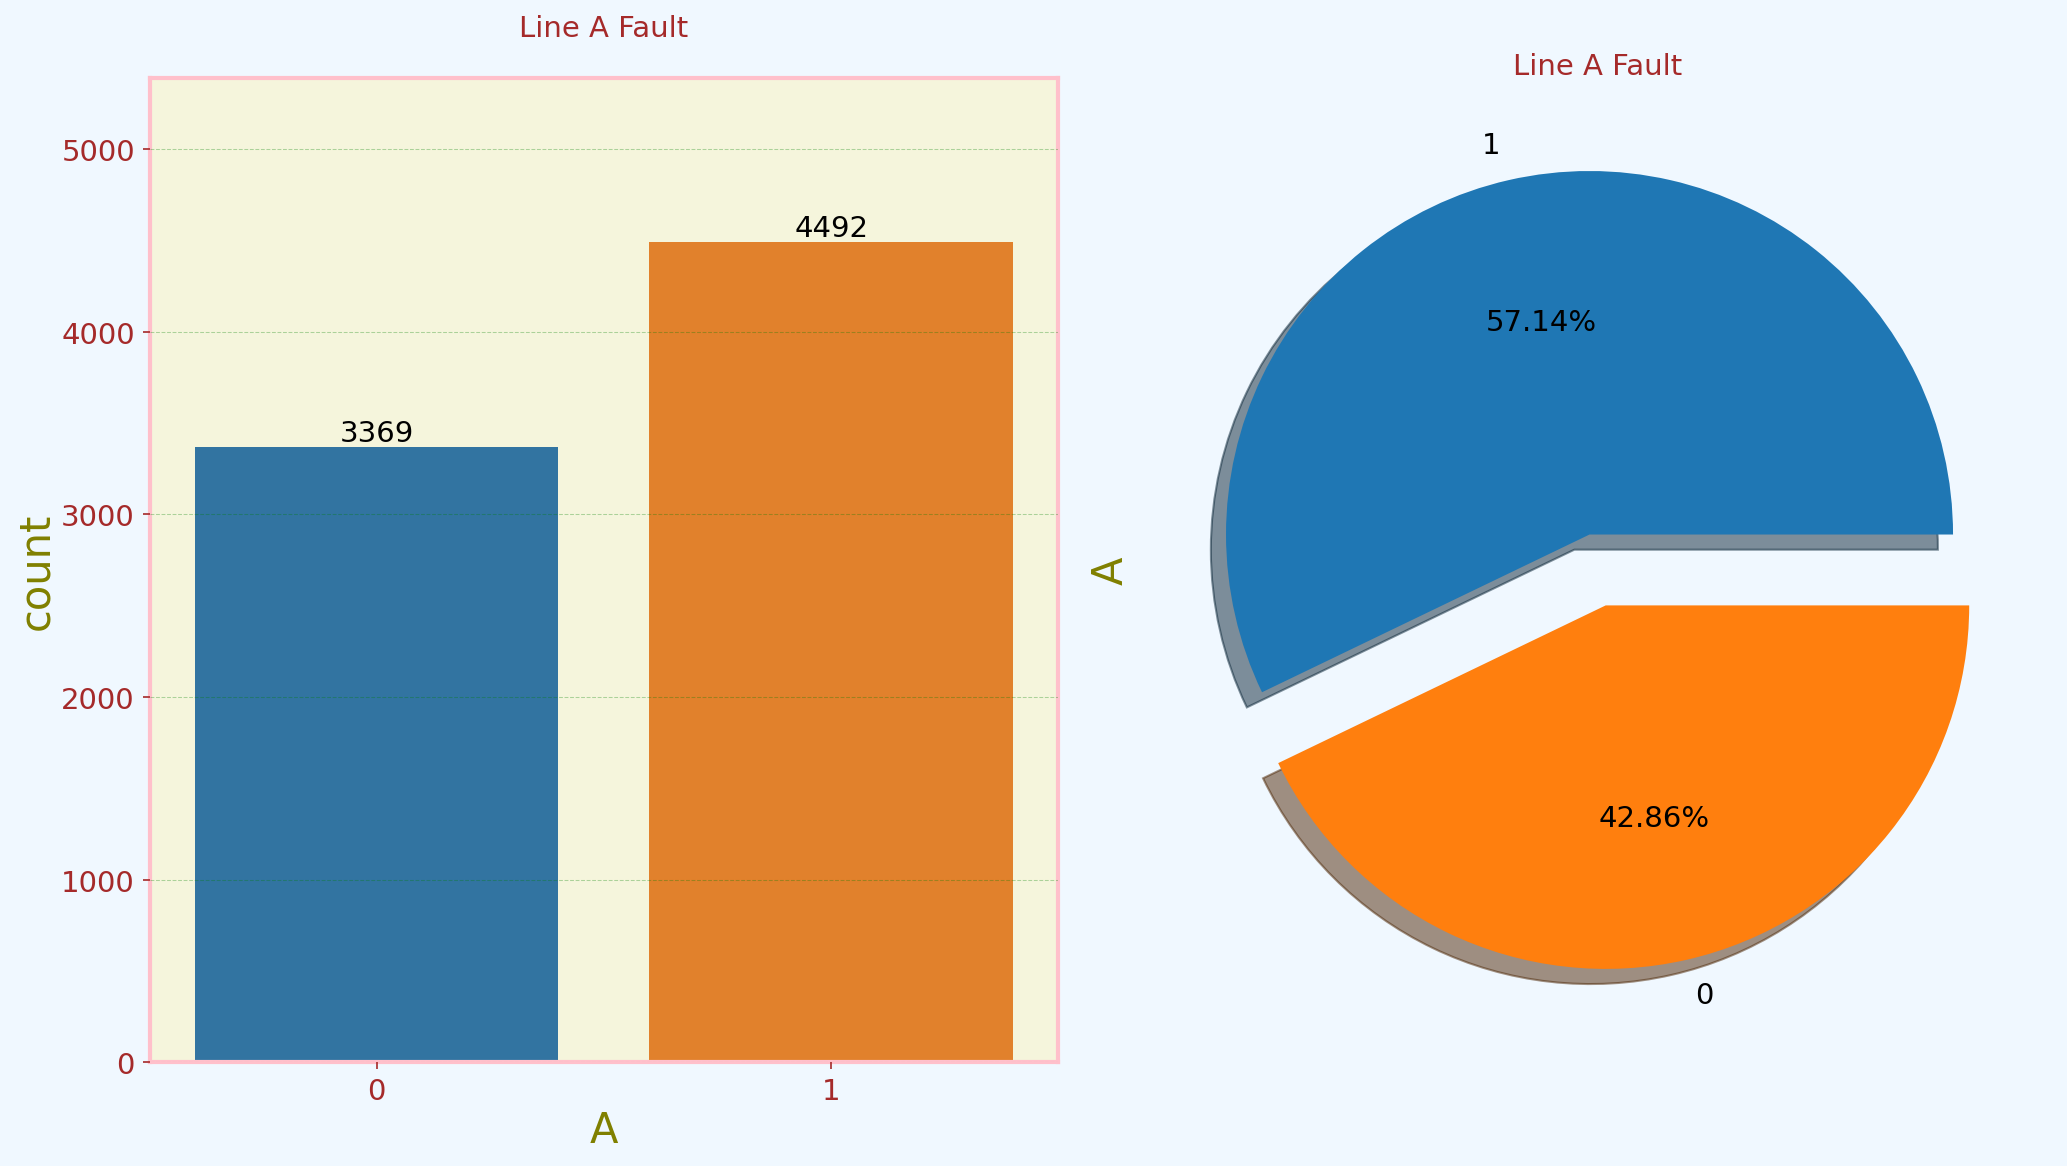

In [25]:
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='A', data=df)
ax.bar_label(ax.containers[0])
plt.title("Line A Fault", fontsize=20,color = 'Brown',font='Lucida Calligraphy',pad=20)

ax =plt.subplot(1,2,2)
ax=df['A'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Line A Fault", fontsize = 20,color='Brown',font='Lucida Calligraphy',pad=20);

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

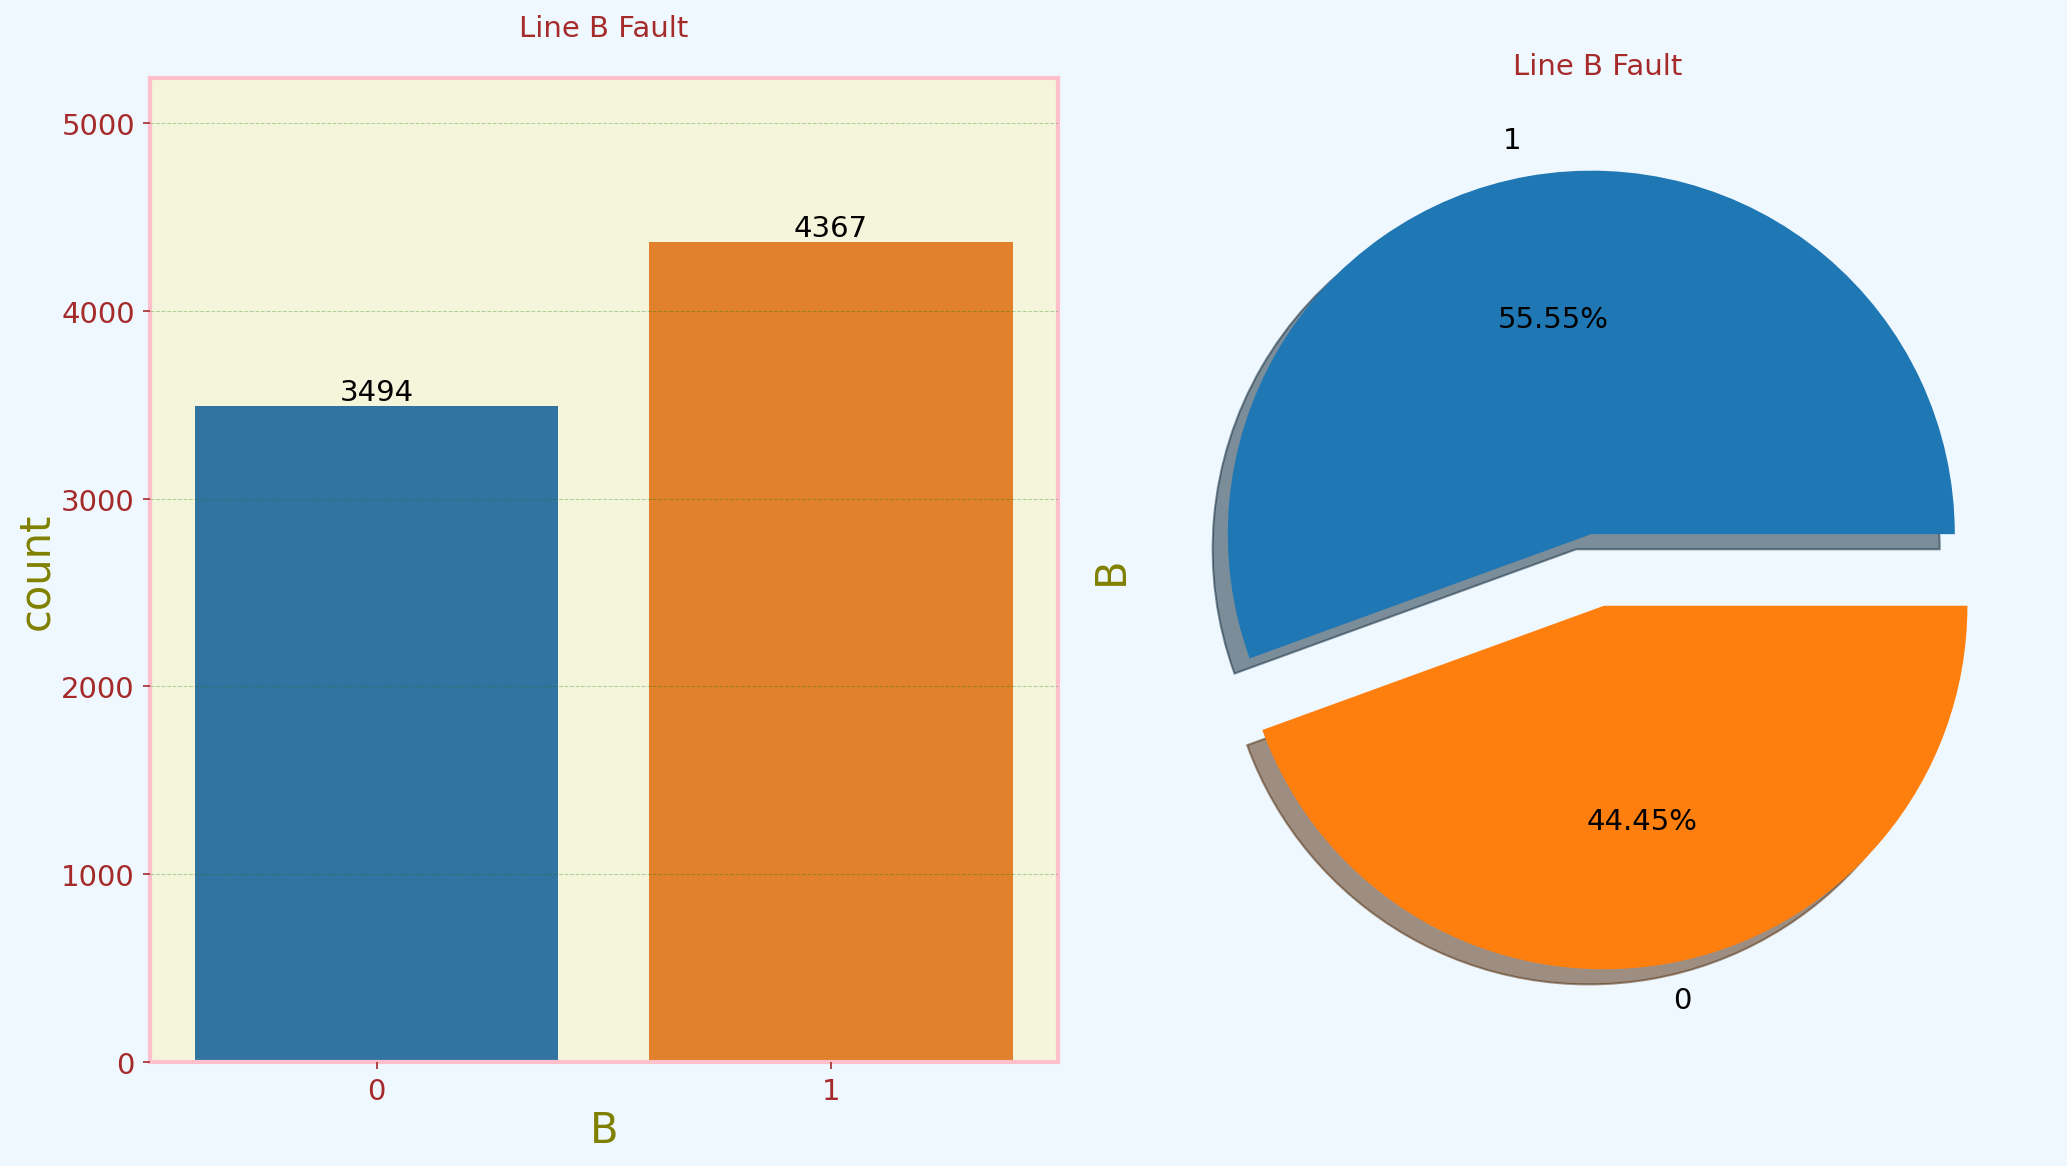

In [26]:
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='B', data=df)
ax.bar_label(ax.containers[0])
plt.title("Line B Fault", fontsize=20,color = 'Brown',font='Lucida Calligraphy',pad=20)

ax =plt.subplot(1,2,2)
ax=df['B'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Line B Fault", fontsize = 20,color='Brown',font='Lucida Calligraphy',pad=20);

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

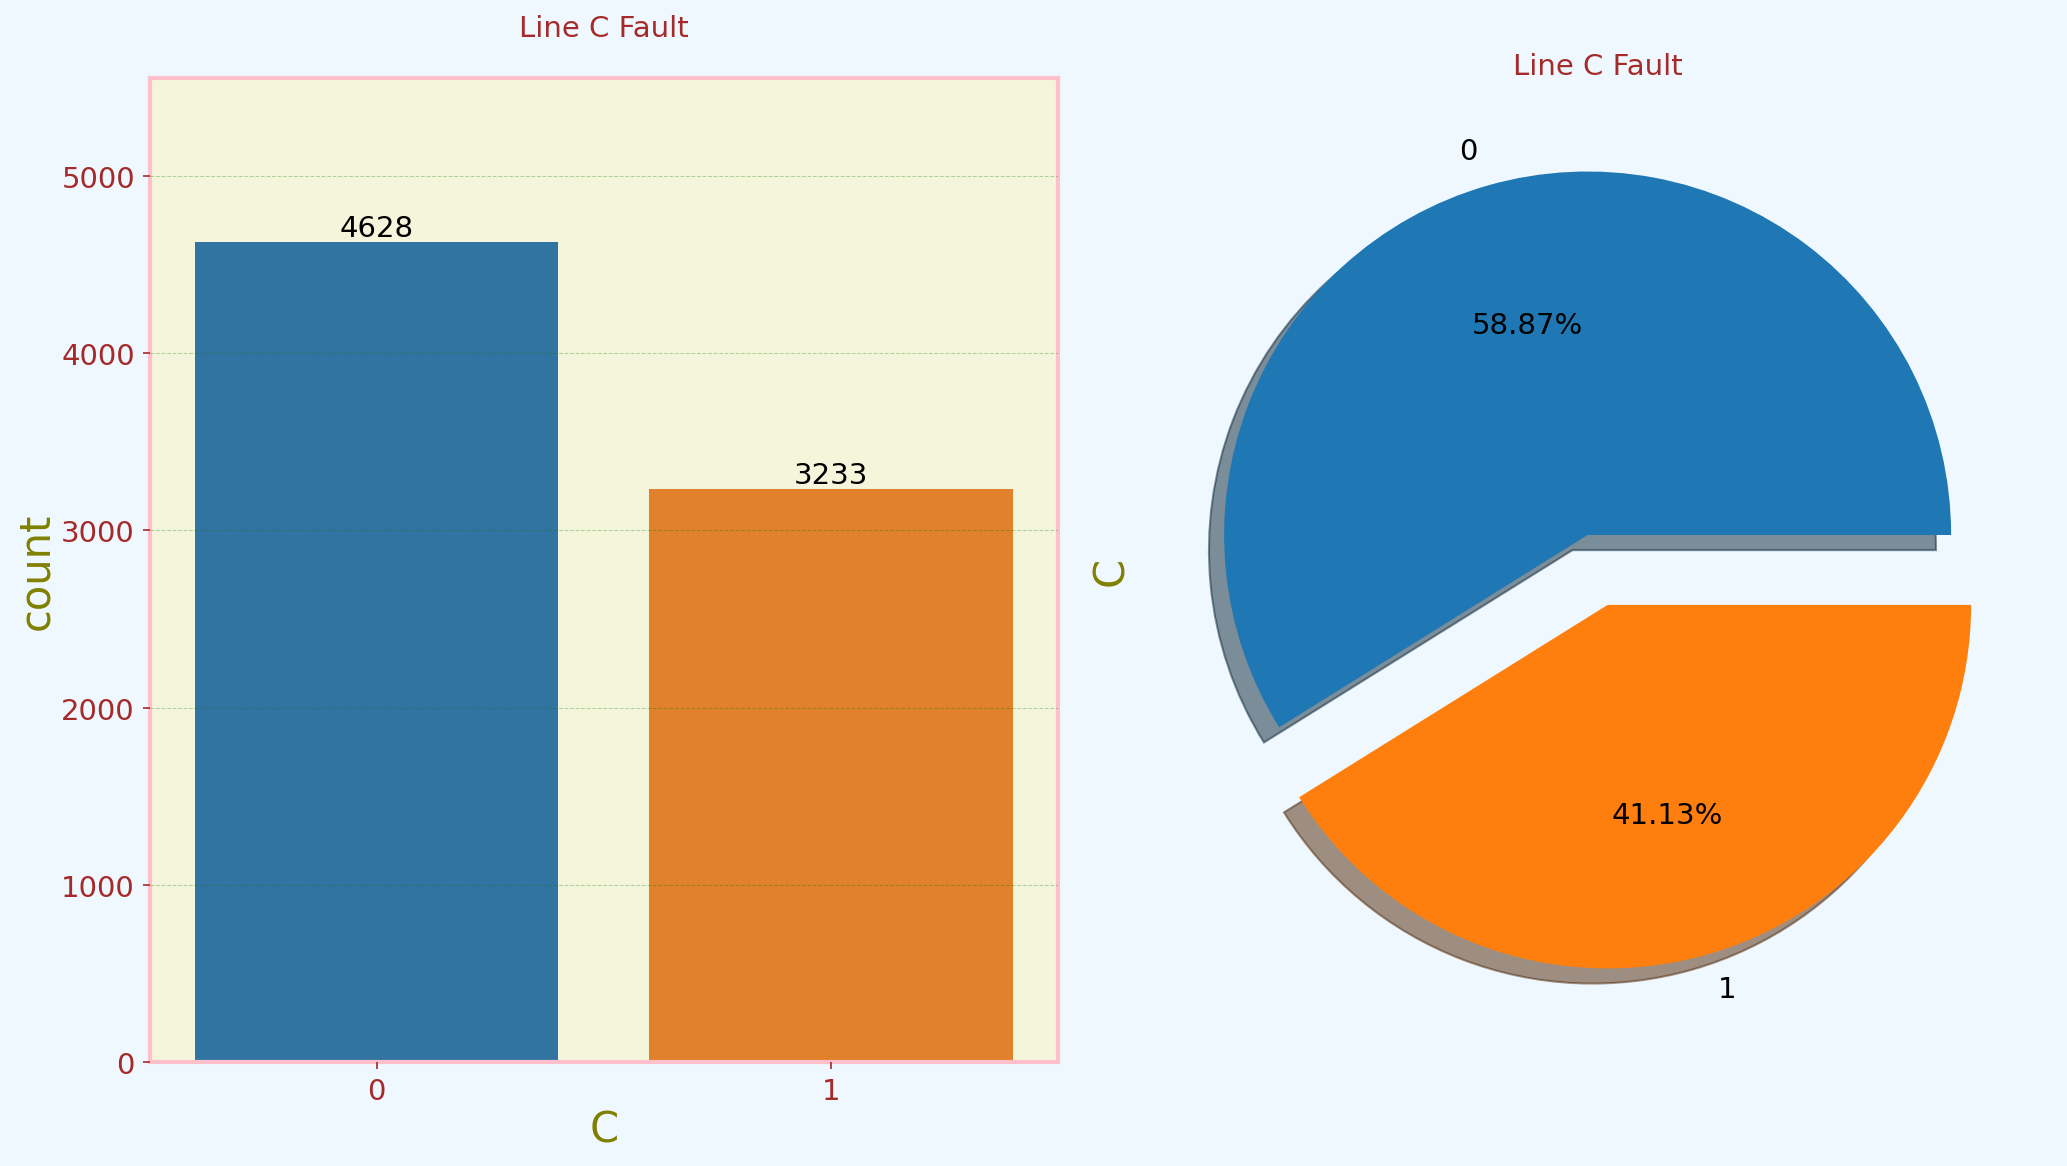

In [27]:
ax = plt.subplot(1,2,1)
ax = sns.countplot(x='C', data=df)
ax.bar_label(ax.containers[0])
plt.title("Line C Fault", fontsize=20,color = 'Brown',font='Lucida Calligraphy',pad=20)

ax =plt.subplot(1,2,2)
ax=df['C'].value_counts().plot.pie(explode=[0.1, 0.1],autopct='%1.2f%%',shadow=True);
ax.set_title(label = "Line C Fault", fontsize = 20,color='Brown',font='Lucida Calligraphy',pad=20);

In [29]:
df['Fault_Type'] = df['G'].astype('str') + df['C'].astype('str') + df['B'].astype('str') + df['A'].astype('str')
df.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,1001
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,1001
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,1001
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,1001
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,1001


In [30]:
df['Fault_Type'][df['Fault_Type'] == '0000' ] = 'NO Fault'
df['Fault_Type'][df['Fault_Type'] == '1001' ] = 'Line A to Ground Fault'
df['Fault_Type'][df['Fault_Type'] == '0110' ] = 'Line B to Line C Fault'
df['Fault_Type'][df['Fault_Type'] == '1011' ] = 'Line A Line B to Ground Fault'
df['Fault_Type'][df['Fault_Type'] == '0111' ] = 'Line A Line B Line C'
df['Fault_Type'][df['Fault_Type'] == '1111' ] = 'Line A Line B Line C to Ground Fault'

/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/978690197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fault_Type'][df['Fault_Type'] == '0000' ] = 'NO Fault'
/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/978690197.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Fault_Type'][df['Fault_Type'] == '1001' ] = 'Line A to Ground Fault'
/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/978690197.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas

In [31]:
df.sample(10).style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
5520,0,0,0,0,-48.379246,-11.126100,37.632469,0.487673,-0.457878,-0.029795,NO Fault
7757,0,0,0,0,-32.828386,93.413156,-63.480833,-0.606959,0.214985,0.391974,NO Fault
6220,0,0,0,0,-71.386885,75.977598,-7.947763,-0.243833,-0.349912,0.593745,NO Fault
4521,1,1,1,1,298.108563,-881.165297,583.088380,-0.028292,-0.012829,0.041121,Line A Line B Line C to Ground Fault
3786,0,1,1,1,-242.780309,-613.283440,858.148330,-0.041502,0.013365,0.028137,Line A Line B Line C
4729,1,1,1,1,-391.420233,881.401329,-489.983041,0.024907,0.017231,-0.042137,Line A Line B Line C to Ground Fault
6041,0,0,0,0,53.590770,13.076878,-70.082871,0.021236,0.527208,-0.548443,NO Fault
4711,1,1,1,1,-154.848567,830.438980,-675.592198,0.033474,0.005746,-0.039220,Line A Line B Line C to Ground Fault
3728,0,1,1,1,-819.636995,126.512349,695.220880,-0.032201,0.039967,-0.007766,Line A Line B Line C
1973,1,0,1,1,-865.647070,364.493534,-19.685487,-0.023780,0.318898,-0.295118,Line A Line B to Ground Fault


In [34]:
df['Fault_Type'].value_counts(ascending=False)

NO Fault                                2365
Line A Line B to Ground Fault           1134
Line A Line B Line C to Ground Fault    1133
Line A to Ground Fault                  1129
Line A Line B Line C                    1096
Line B to Line C Fault                  1004
Name: Fault_Type, dtype: int64

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

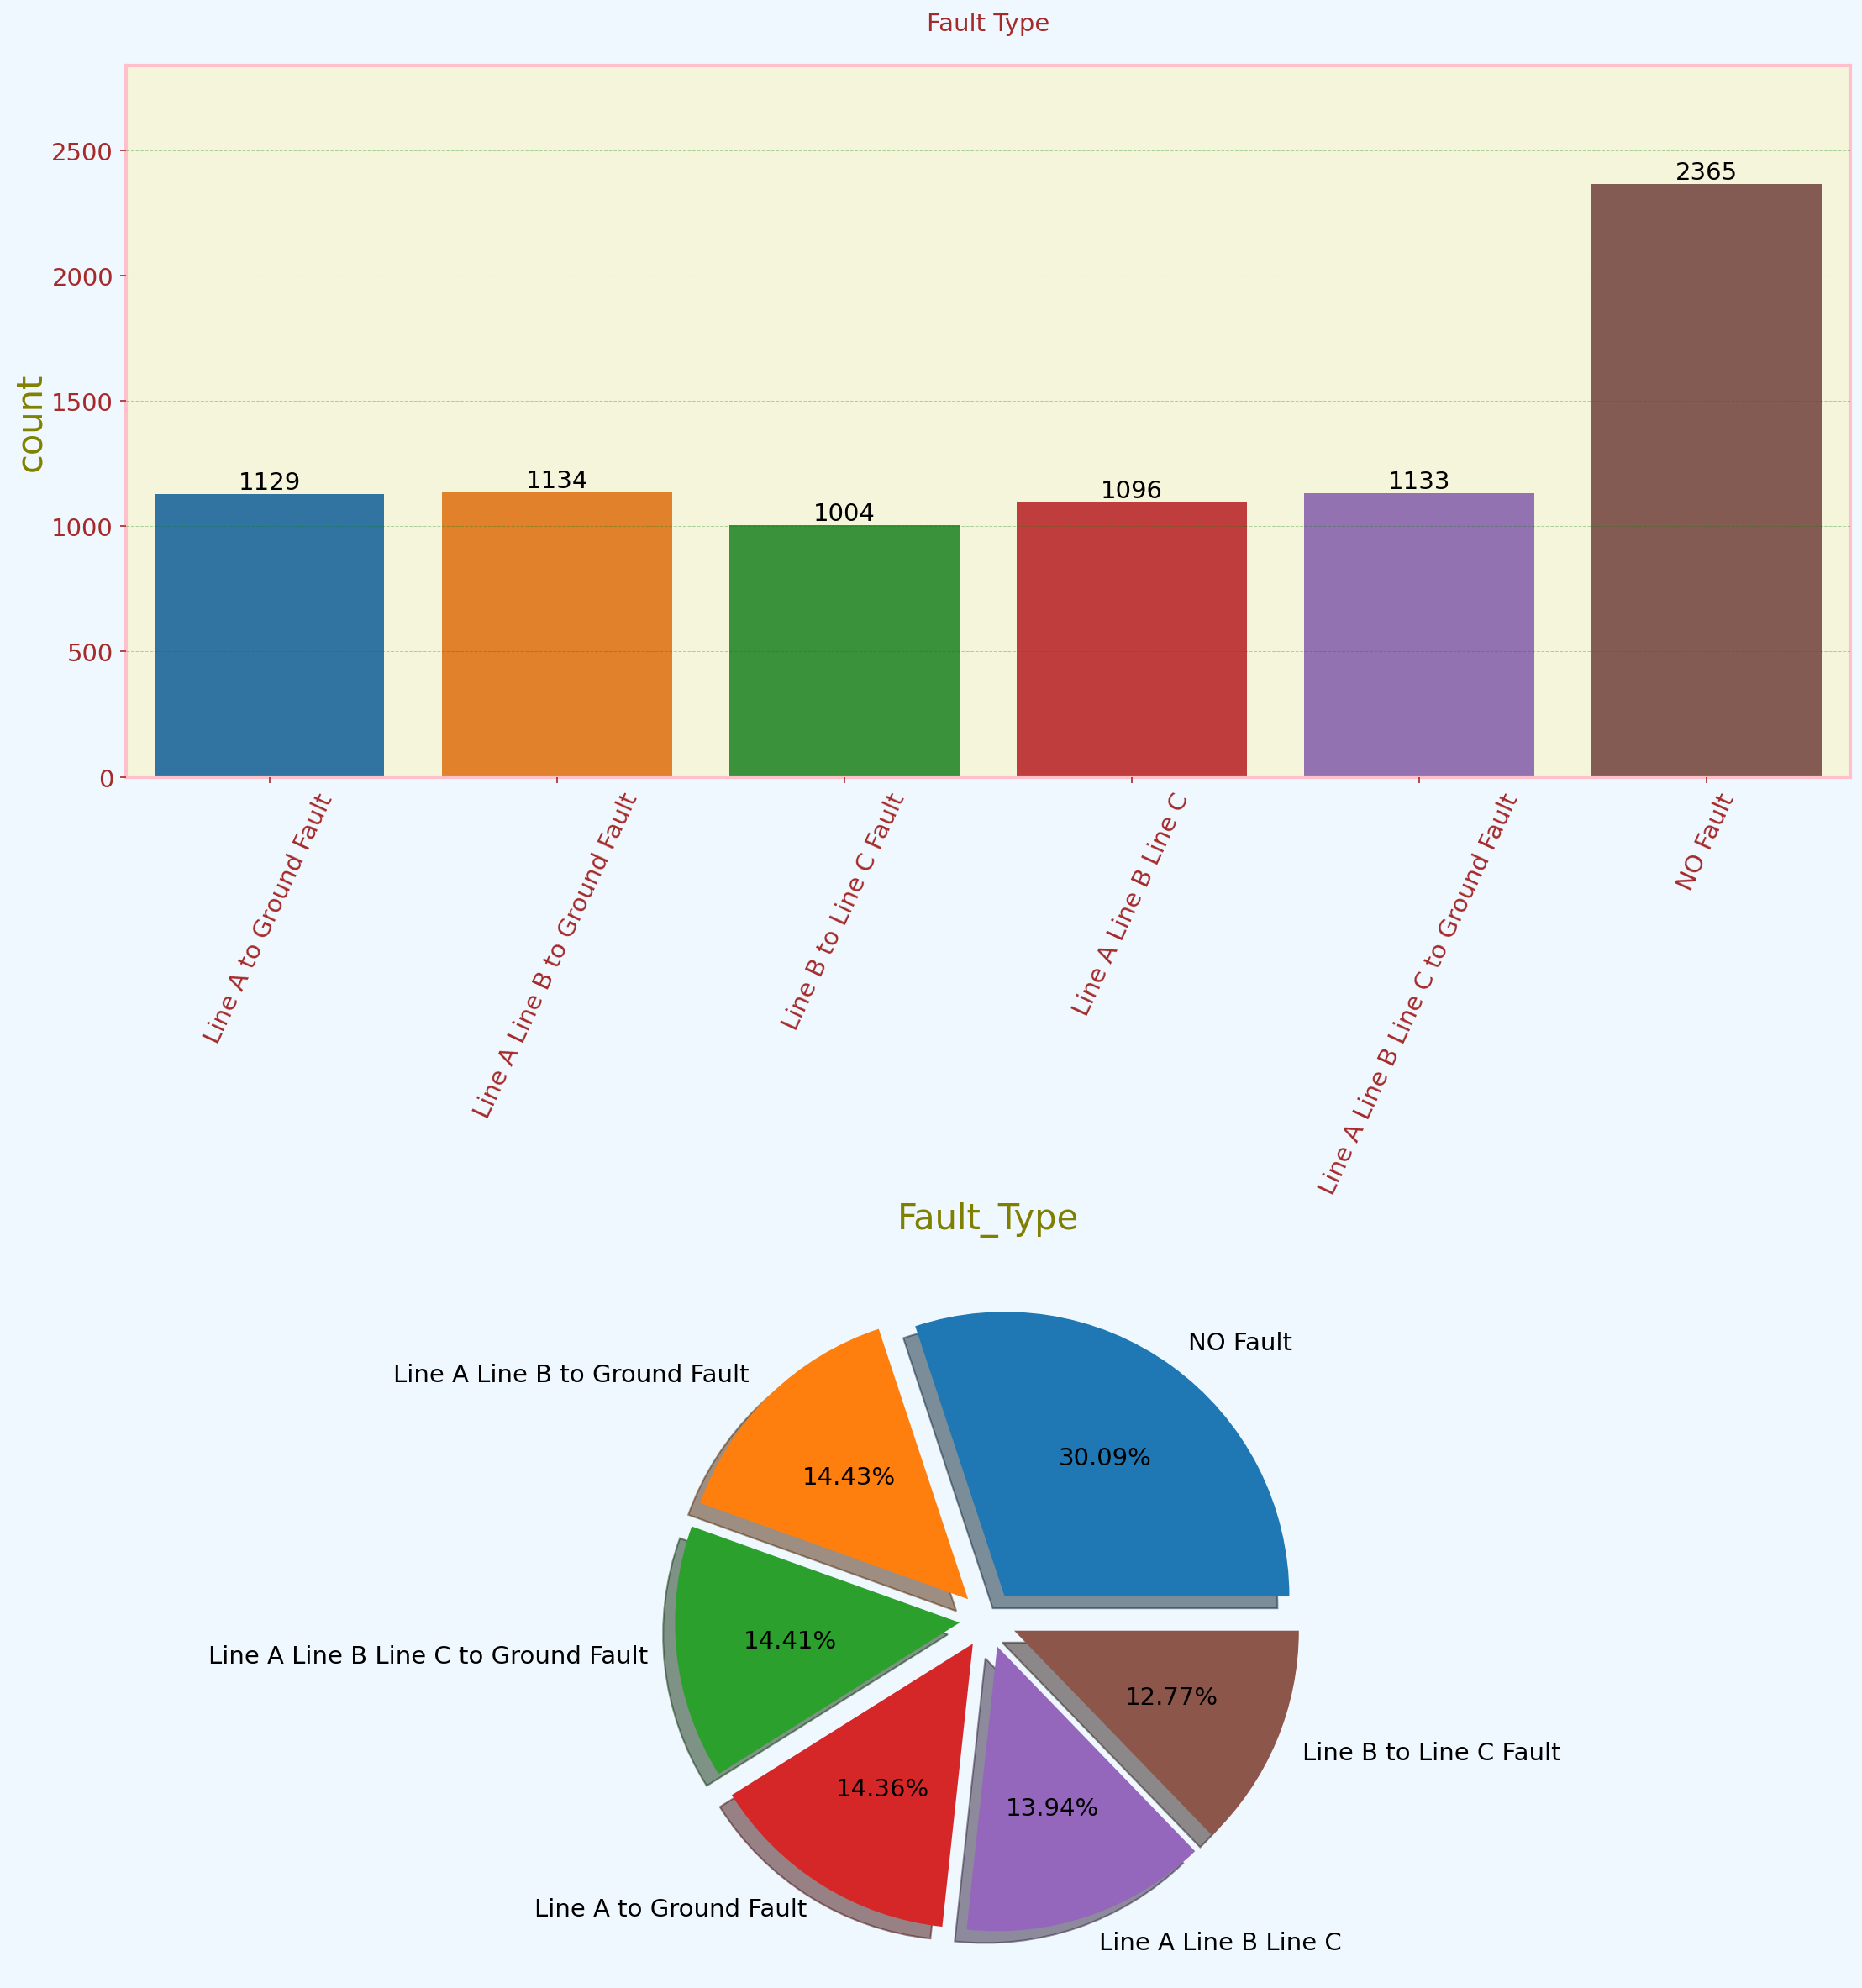

In [35]:
ax = plt.figure(figsize = (15,16))
ax = plt.subplot(2,1,1)
ax = sns.countplot(x='Fault_Type', data=df)
ax.bar_label(ax.containers[0])
plt.title("Fault Type", fontsize=20,color = 'Brown',font='Lucida Calligraphy',pad=20)
plt.xticks(rotation=65)
plt.tight_layout()

ax =plt.subplot(2,1,2)
ax=df['Fault_Type'].value_counts().plot.pie(explode=[0.1, 0.1,0.1,0.1, 0.1,0.1],autopct='%1.2f%%',shadow=True);
plt.tight_layout()
plt.axis('off');


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

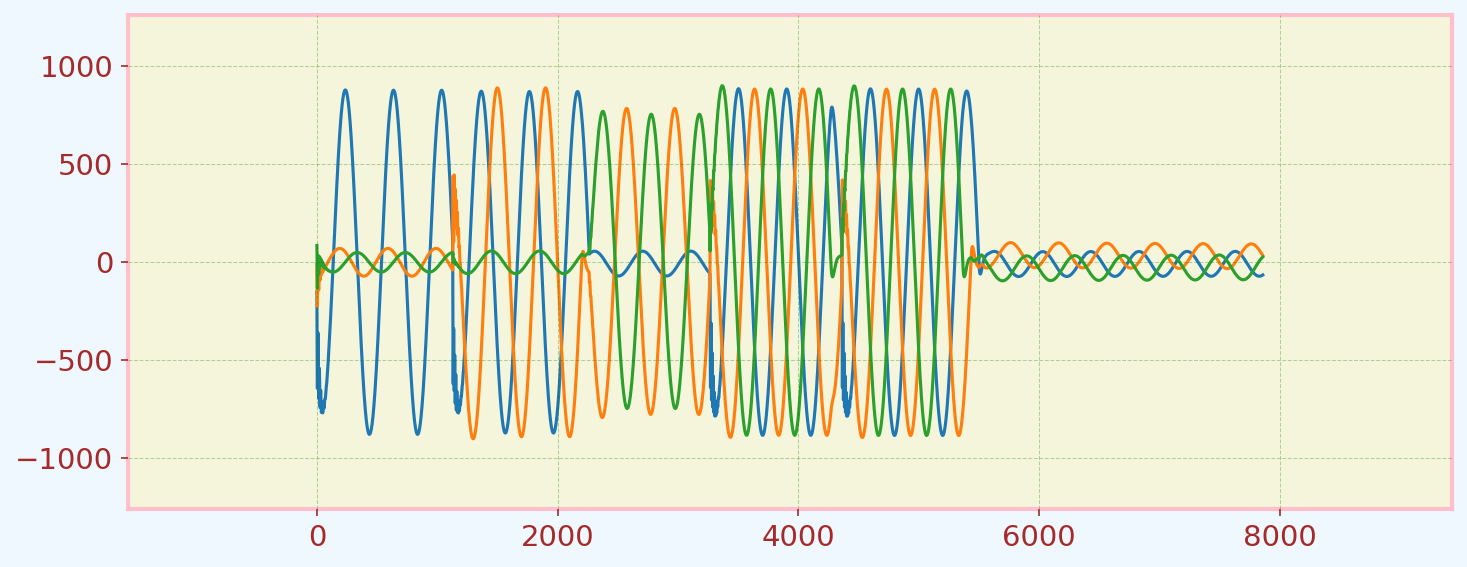

In [37]:
plt.figure(figsize = (10,4))
plt.plot(df["Ia"])
plt.plot(df["Ib"])
plt.plot(df["Ic"]);

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

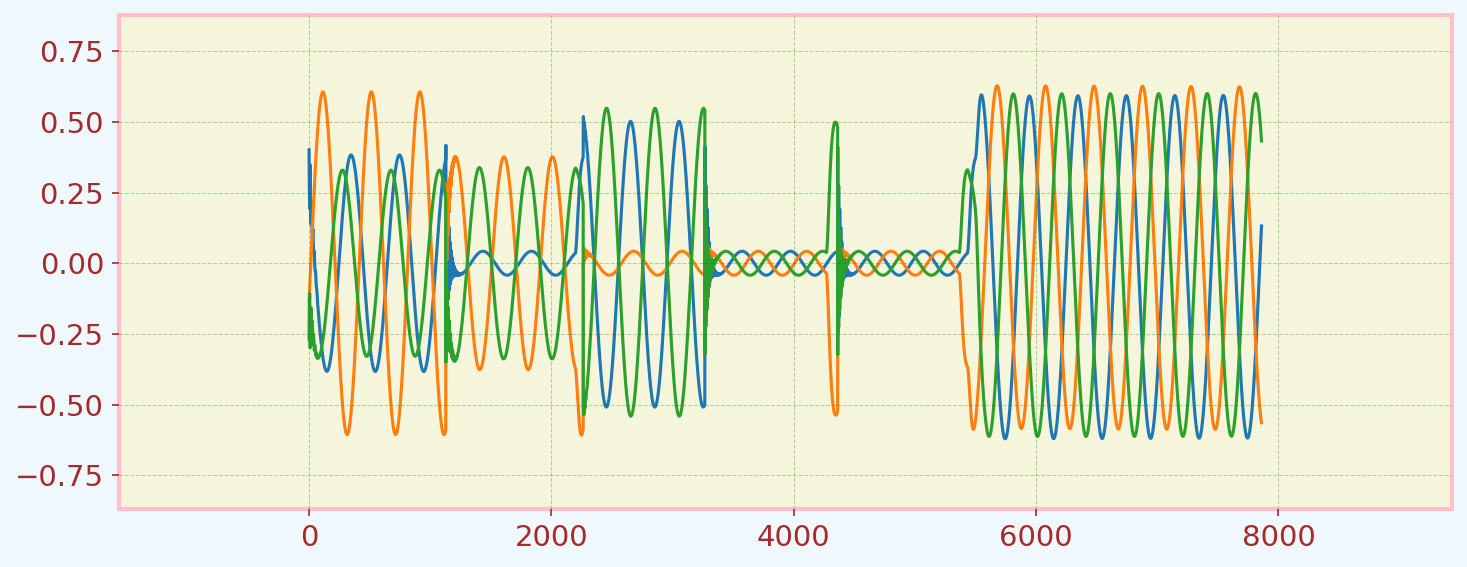

In [38]:
plt.figure(figsize = (10,4))
plt.plot(df["Va"])
plt.plot(df["Vb"])
plt.plot(df["Vc"]);

/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/3013510380.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Va'], rug = True, kde = False)
/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/3013510380.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['Ia

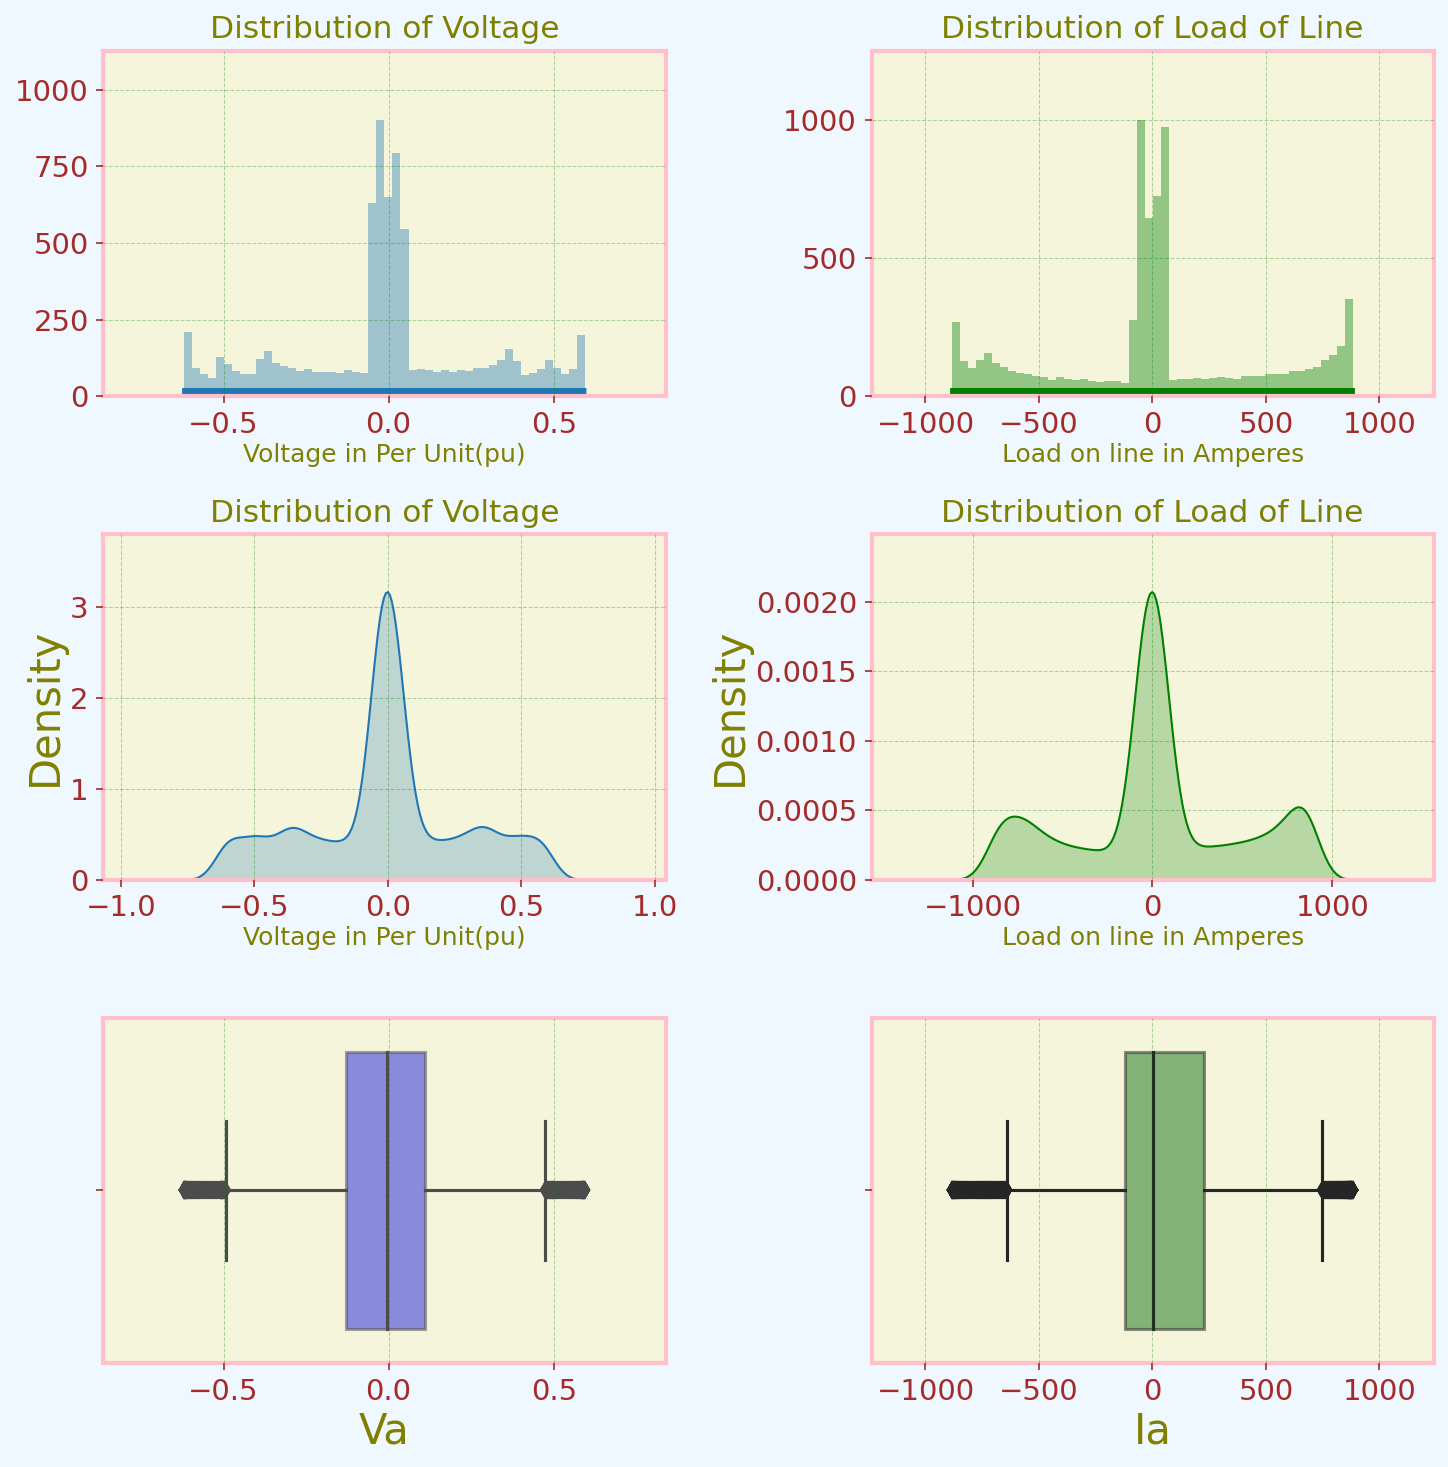

In [39]:
plt.figure(figsize= (15,10))
#plt.suptitle("Distributions of Different Features", fontsize = 20)
#Histograms
plt.subplot(3,3,1)
sns.distplot(df['Va'], rug = True, kde = False)
plt.xlabel('Voltage in Per Unit(pu)', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,2)
sns.distplot(df['Ia'], color= 'green',rug = True, kde = False)
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)


#Kde Plots
plt.subplot(3,3,4)
sns.kdeplot(df['Va'], shade = True)
plt.xlabel('Voltage in Per Unit(pu)', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,5)
sns.kdeplot(df['Ia'], shade = True, color = 'g')
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)


#Box Plots
plt.subplot(3,3,7)
sns.boxplot(x = df['Va'], orient = 'v',color= 'b', boxprops=dict(alpha=.5))
plt.subplot(3,3,8)
sns.boxplot(x = df['Ia'], orient = 'v', color= 'g', boxprops=dict(alpha=.5))


plt.tight_layout()
plt.show()

In [40]:
No_Fault = df[df['Fault_Type'] == 'NO Fault' ]
No_Fault.sample(5).style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
5792,0,0,0,0,-61.115735,94.280889,-36.630021,-0.461308,-0.109699,0.571007,NO Fault
6310,0,0,0,0,-29.433301,-6.709986,32.815147,0.503825,-0.510678,0.006854,NO Fault
6216,0,0,0,0,-70.578847,78.963969,-11.743463,-0.278592,-0.319081,0.597673,NO Fault
6932,0,0,0,0,-9.263437,88.314175,-82.185764,-0.607045,0.420748,0.186297,NO Fault
6679,0,0,0,0,-54.803205,19.298071,32.292948,0.296934,-0.585909,0.288975,NO Fault


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

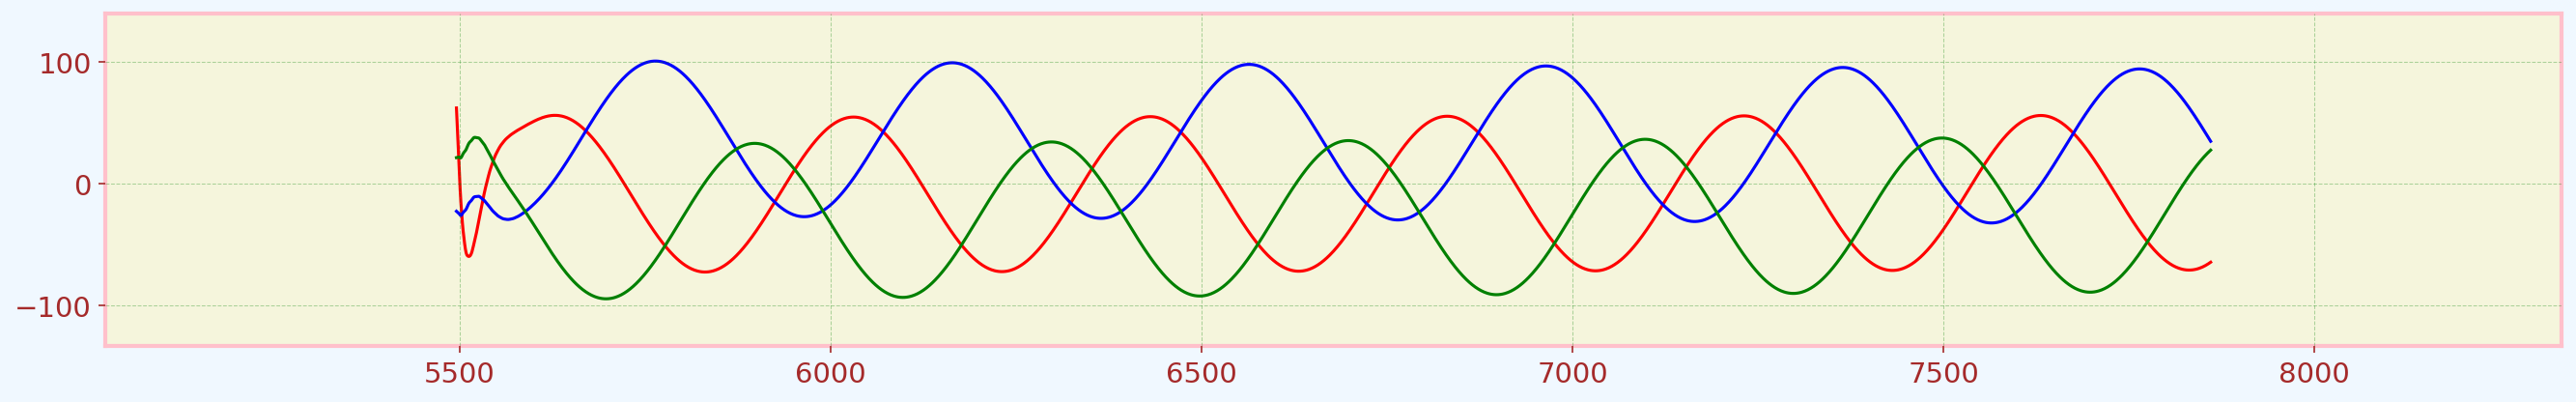

In [41]:
ax = plt.figure(figsize = (18,3))
ax = plt.plot(No_Fault["Ia"],'r')
ax = plt.plot(No_Fault["Ib"],'b')
ax = plt.plot(No_Fault["Ic"],'g');

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

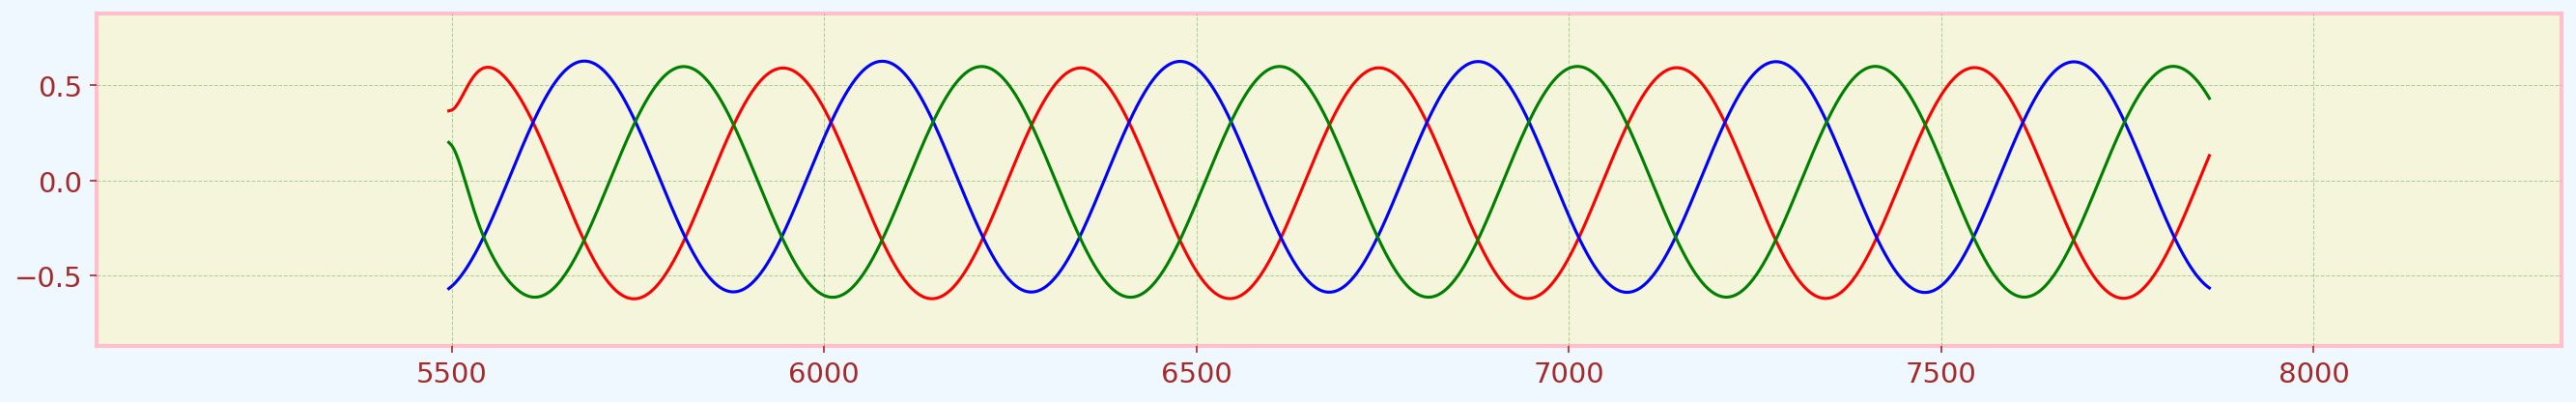

In [42]:
ax = plt.figure(figsize = (18,3))
ax = plt.plot(No_Fault["Va"],'r')
ax = plt.plot(No_Fault["Vb"],'b')
ax = plt.plot(No_Fault["Vc"],'g');


/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/3312334111.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(No_Fault['Va'], rug = True, kde = False)
/var/folders/v2/xjtc_bt56v1_fs02x5d8zng40000gn/T/ipykernel_8533/3312334111.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(

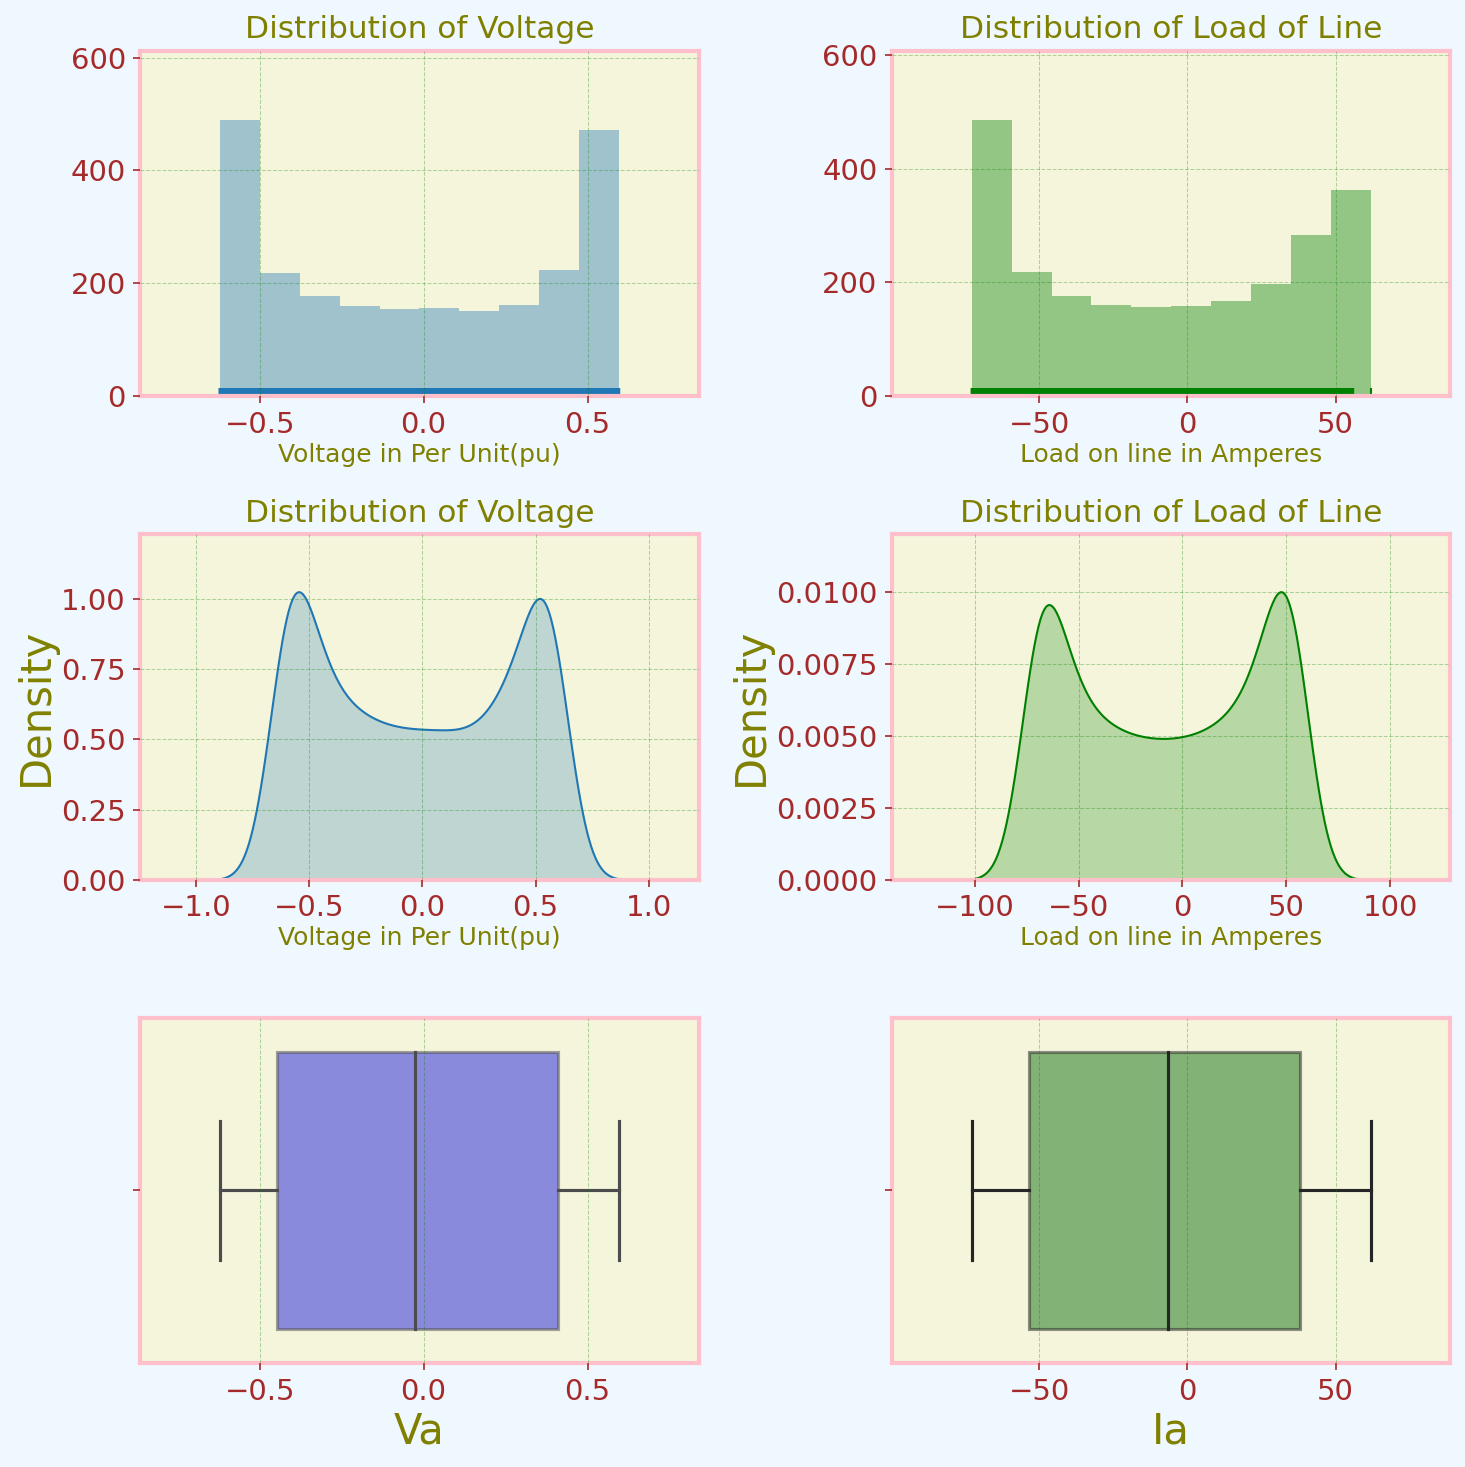

In [43]:
plt.figure(figsize= (15,10))
#plt.suptitle("Distributions of Different Features", fontsize = 20)
#Histograms
plt.subplot(3,3,1)
sns.distplot(No_Fault['Va'], rug = True, kde = False)
plt.xlabel('Voltage in Per Unit(pu)', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,2)
sns.distplot(No_Fault['Ia'], color= 'green',rug = True, kde = False)
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)


#Kde Plots
plt.subplot(3,3,4)
sns.kdeplot(No_Fault['Va'], shade = True)
plt.xlabel('Voltage in Per Unit(pu)', fontsize = 12)
plt.title('Distribution of Voltage',fontsize = 15)

plt.subplot(3,3,5)
sns.kdeplot(No_Fault['Ia'], shade = True, color = 'g')
plt.title('Distribution of Load of Line',fontsize = 15)
plt.xlabel('Load on line in Amperes', fontsize = 12)


#Box Plots
plt.subplot(3,3,7)
sns.boxplot(x = No_Fault['Va'], orient = 'v',color= 'b', boxprops=dict(alpha=.5))
plt.subplot(3,3,8)
sns.boxplot(x = No_Fault['Ia'], orient = 'v', color= 'g', boxprops=dict(alpha=.5))


plt.tight_layout()
plt.show()


In [44]:
Line_AG_Fault = df[df['Fault_Type'] == 'Line A to Ground Fault' ]
Line_AG_Fault.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,Line A to Ground Fault
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,Line A to Ground Fault
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,Line A to Ground Fault
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,Line A to Ground Fault
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,Line A to Ground Fault


In [45]:
Line_ABG_Fault = df[df['Fault_Type'] == 'Line A Line B to Ground Fault' ]
Line_ABG_Fault.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
1129,1,0,1,1,-83.713374,42.102812,38.015631,0.416930,-0.066439,-0.350491,Line A Line B to Ground Fault
1130,1,0,1,1,-304.258650,243.536374,42.670680,0.097053,0.089765,-0.186818,Line A Line B to Ground Fault
1131,1,0,1,1,-487.104324,377.325956,29.573282,-0.132447,0.203226,-0.070779,Line A Line B to Ground Fault
1132,1,0,1,1,-603.543045,439.399623,9.638569,-0.248609,0.263483,-0.014873,Line A Line B to Ground Fault
1133,1,0,1,1,-620.718849,423.222790,0.613787,-0.226918,0.254651,-0.027733,Line A Line B to Ground Fault


In [46]:
Line_BC_Fault = df[df['Fault_Type'] == 'Line B to Line C Fault' ]
Line_BC_Fault.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
2263,0,1,1,0,41.764455,-93.940215,55.022192,0.517510,-0.003685,-0.513825,Line B to Line C Fault
2264,0,1,1,0,42.394348,-105.038998,65.494029,0.518491,-0.008071,-0.510420,Line B to Line C Fault
2265,0,1,1,0,43.010571,-105.734383,65.569977,0.511217,0.003798,-0.515015,Line B to Line C Fault
2266,0,1,1,0,43.612456,-100.121739,59.347319,0.499096,0.025105,-0.524201,Line B to Line C Fault
2267,0,1,1,0,44.202230,-95.078643,53.707382,0.487527,0.045052,-0.532579,Line B to Line C Fault


In [47]:
Line_ABCG_Fault = df[df['Fault_Type'] == 'Line A Line B Line C to Ground Fault' ]
Line_ABCG_Fault.head().style.set_properties(**{'background-color': 'blue',
                           'color': 'white',
                           'border-color': 'darkblack'})

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
4363,1,1,1,1,-99.252463,52.717974,48.341534,0.410059,-0.086914,-0.323145,Line A Line B Line C to Ground Fault
4364,1,1,1,1,-342.238819,224.821345,119.149604,0.095347,-0.002326,-0.093021,Line A Line B Line C to Ground Fault
4365,1,1,1,1,-526.874012,351.614759,176.674369,-0.130437,0.055441,0.074996,Line A Line B Line C to Ground Fault
4366,1,1,1,1,-633.768916,420.246089,214.577137,-0.244709,0.082066,0.162643,Line A Line B Line C to Ground Fault
4367,1,1,1,1,-639.566896,415.329565,225.117414,-0.223359,0.073192,0.150167,Line A Line B Line C to Ground Fault


In [48]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Fault_Type'] = encoder.fit_transform(df['Fault_Type'])
df.head()

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,Fault_Type
0,1,0,0,1,-151.291812,-9.677452,85.800162,0.400750,-0.132935,-0.267815,3
1,1,0,0,1,-336.186183,-76.283262,18.328897,0.312732,-0.123633,-0.189099,3
2,1,0,0,1,-502.891583,-174.648023,-80.924663,0.265728,-0.114301,-0.151428,3
3,1,0,0,1,-593.941905,-217.703359,-124.891924,0.235511,-0.104940,-0.130570,3
4,1,0,0,1,-643.663617,-224.159427,-132.282815,0.209537,-0.095554,-0.113983,3


In [49]:
X = df.drop(['Fault_Type'],axis=1)
y = df['Fault_Type']

In [50]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.20,random_state=21)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' 

Training Accuracy    : 90.17 %
Model Accuracy Score : 89.57 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.56      1.00      0.72       213
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       248
           3       1.00      1.00      1.00       227
           4       1.00      0.17      0.29       198
           5       1.00      1.00      1.00       456

    accuracy                           0.90      1573
   macro avg       0.93      0.86      0.84      1573
weighted avg       0.94      0.90      0.87      1573

--------------------------------------------------------


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

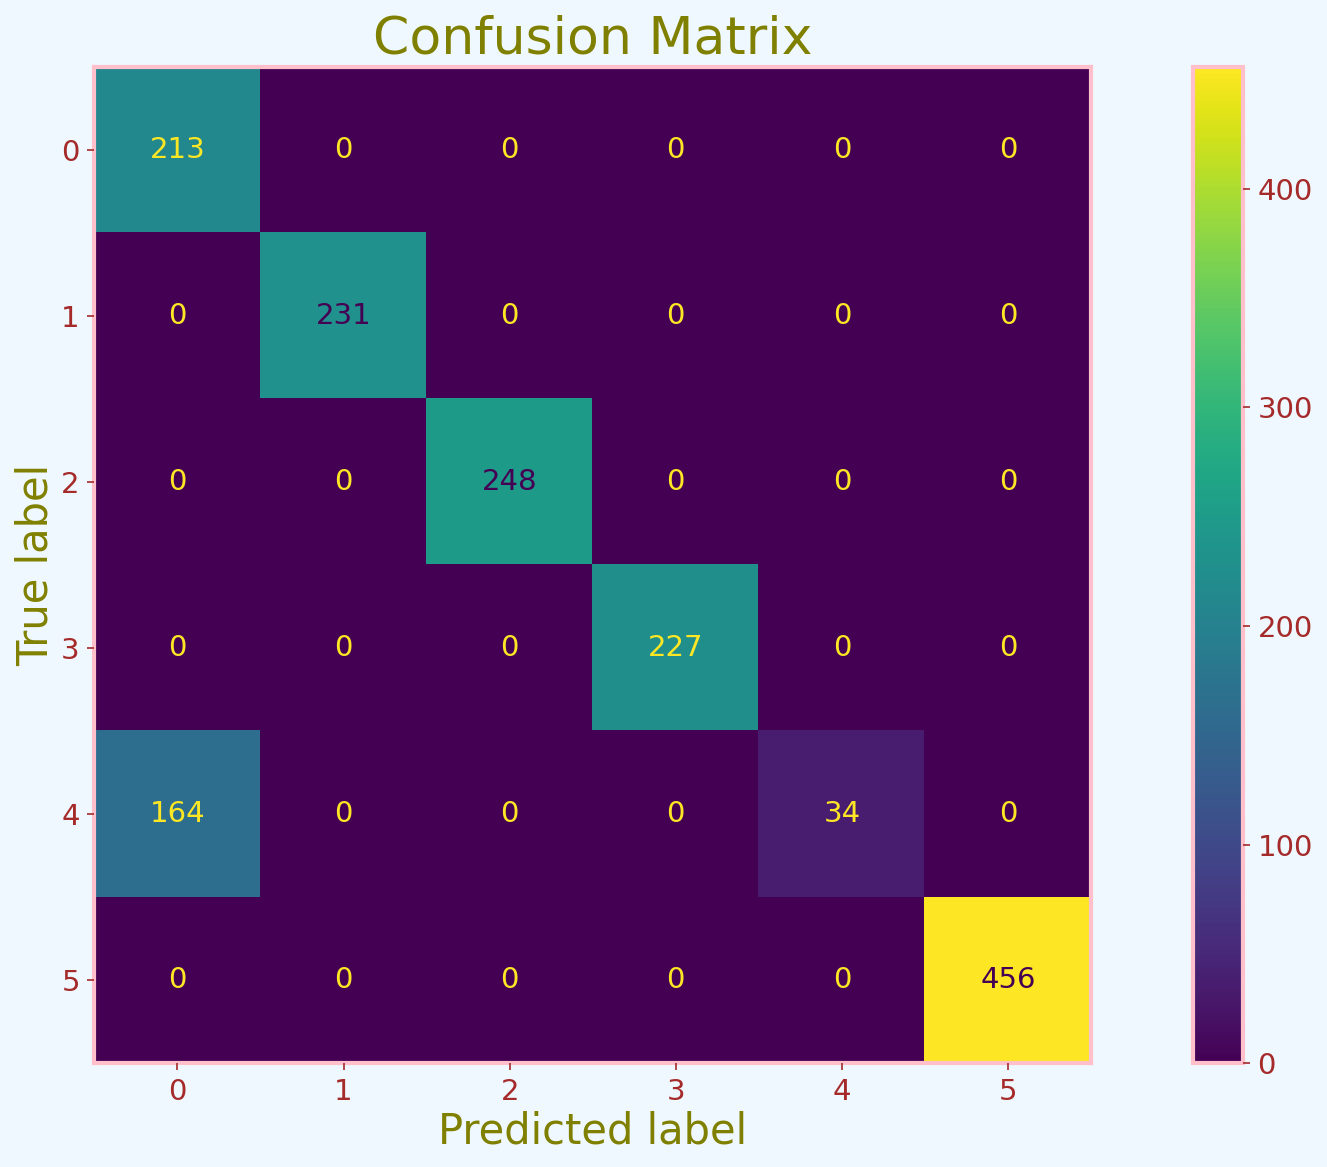

In [52]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

# Train model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

# Accuracy scores
log_train = round(logreg.score(X_train, y_train) * 100, 2)
log_accuracy = round(accuracy_score(y_test, y_pred_lr) * 100, 2)

print("Training Accuracy    :", log_train, "%")
print("Model Accuracy Score :", log_accuracy, "%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n", classification_report(y_test, y_pred_lr))
print("\033[1m--------------------------------------------------------\033[0m")

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(logreg, X_test, y_test)
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

Training Accuracy    : 100.0 %
Model Accuracy Score : 100.0 %
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       231
           2       1.00      1.00      1.00       248
           3       1.00      1.00      1.00       227
           4       1.00      1.00      1.00       198
           5       1.00      1.00      1.00       456

    accuracy                           1.00      1573
   macro avg       1.00      1.00      1.00      1573
weighted avg       1.00      1.00      1.00      1573

--------------------------------------------------------


findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

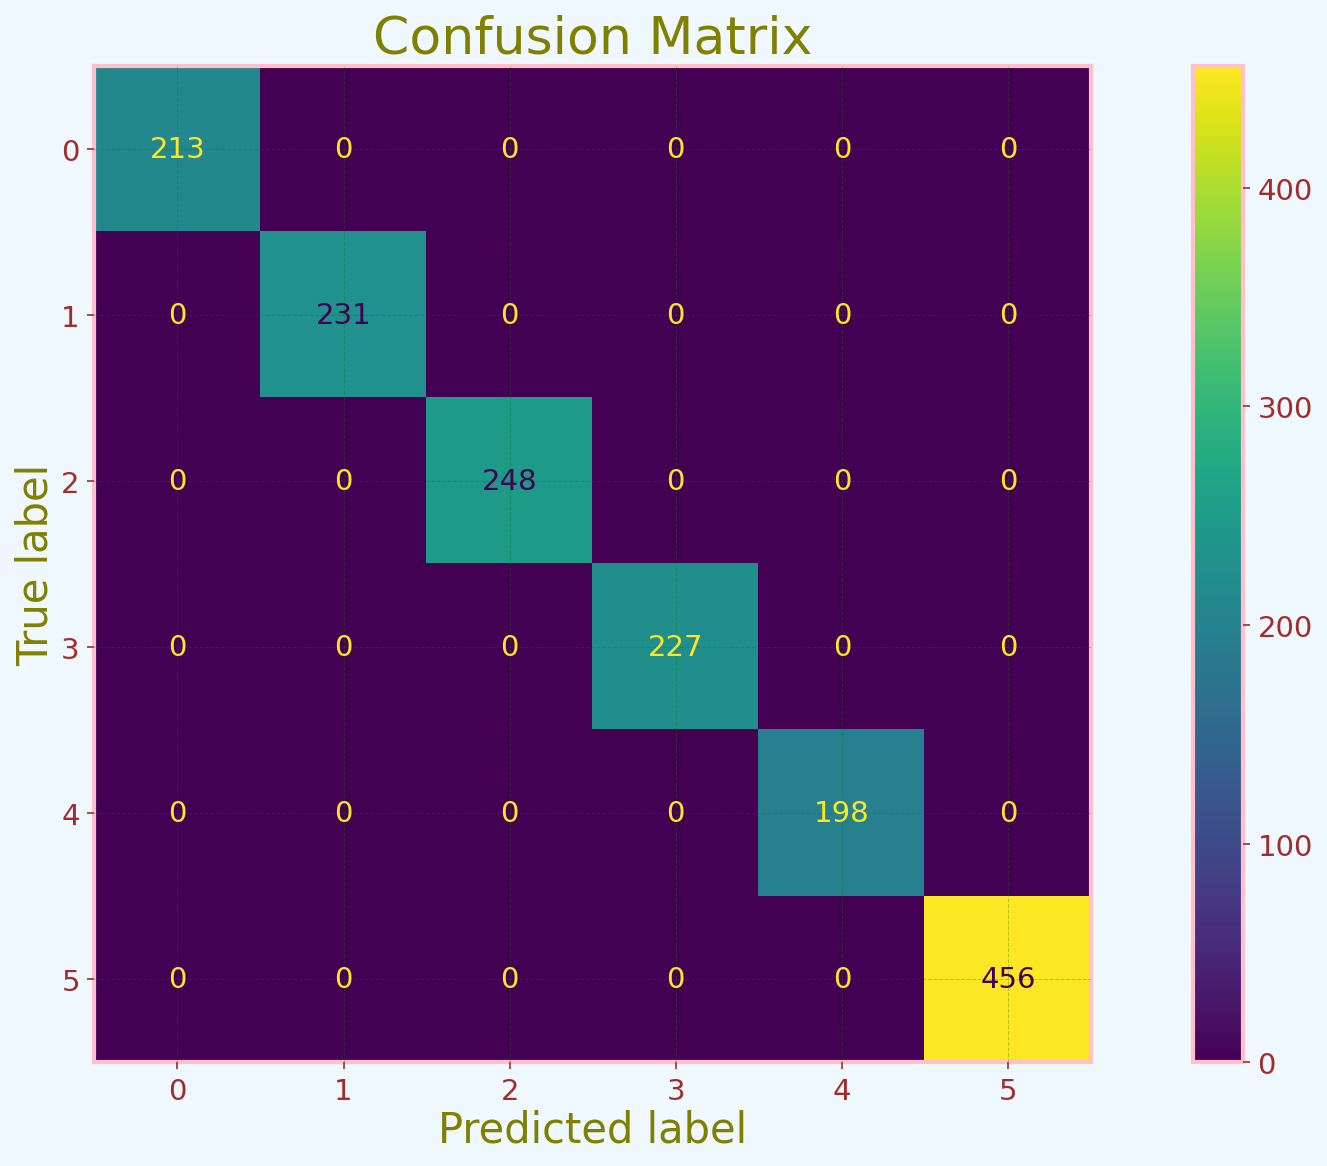

In [54]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
decision = DecisionTreeClassifier()
decision.fit(X_train, y_train)
y_pred_dec = decision.predict(X_test)

decision_train = round(decision.score(X_train, y_train) * 100, 2)
decision_accuracy = round(accuracy_score(y_pred_dec, y_test) * 100, 2)

print("Training Accuracy    :",decision_train ,"%")
print("Model Accuracy Score :",decision_accuracy ,"%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_pred_dec))
print("\033[1m--------------------------------------------------------\033[0m")
ConfusionMatrixDisplay.from_estimator(decision, X_test, y_test);
plt.title('Confusion Matrix');

findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucida Calligraphy' not found.
findfont: Font family 'Lucid

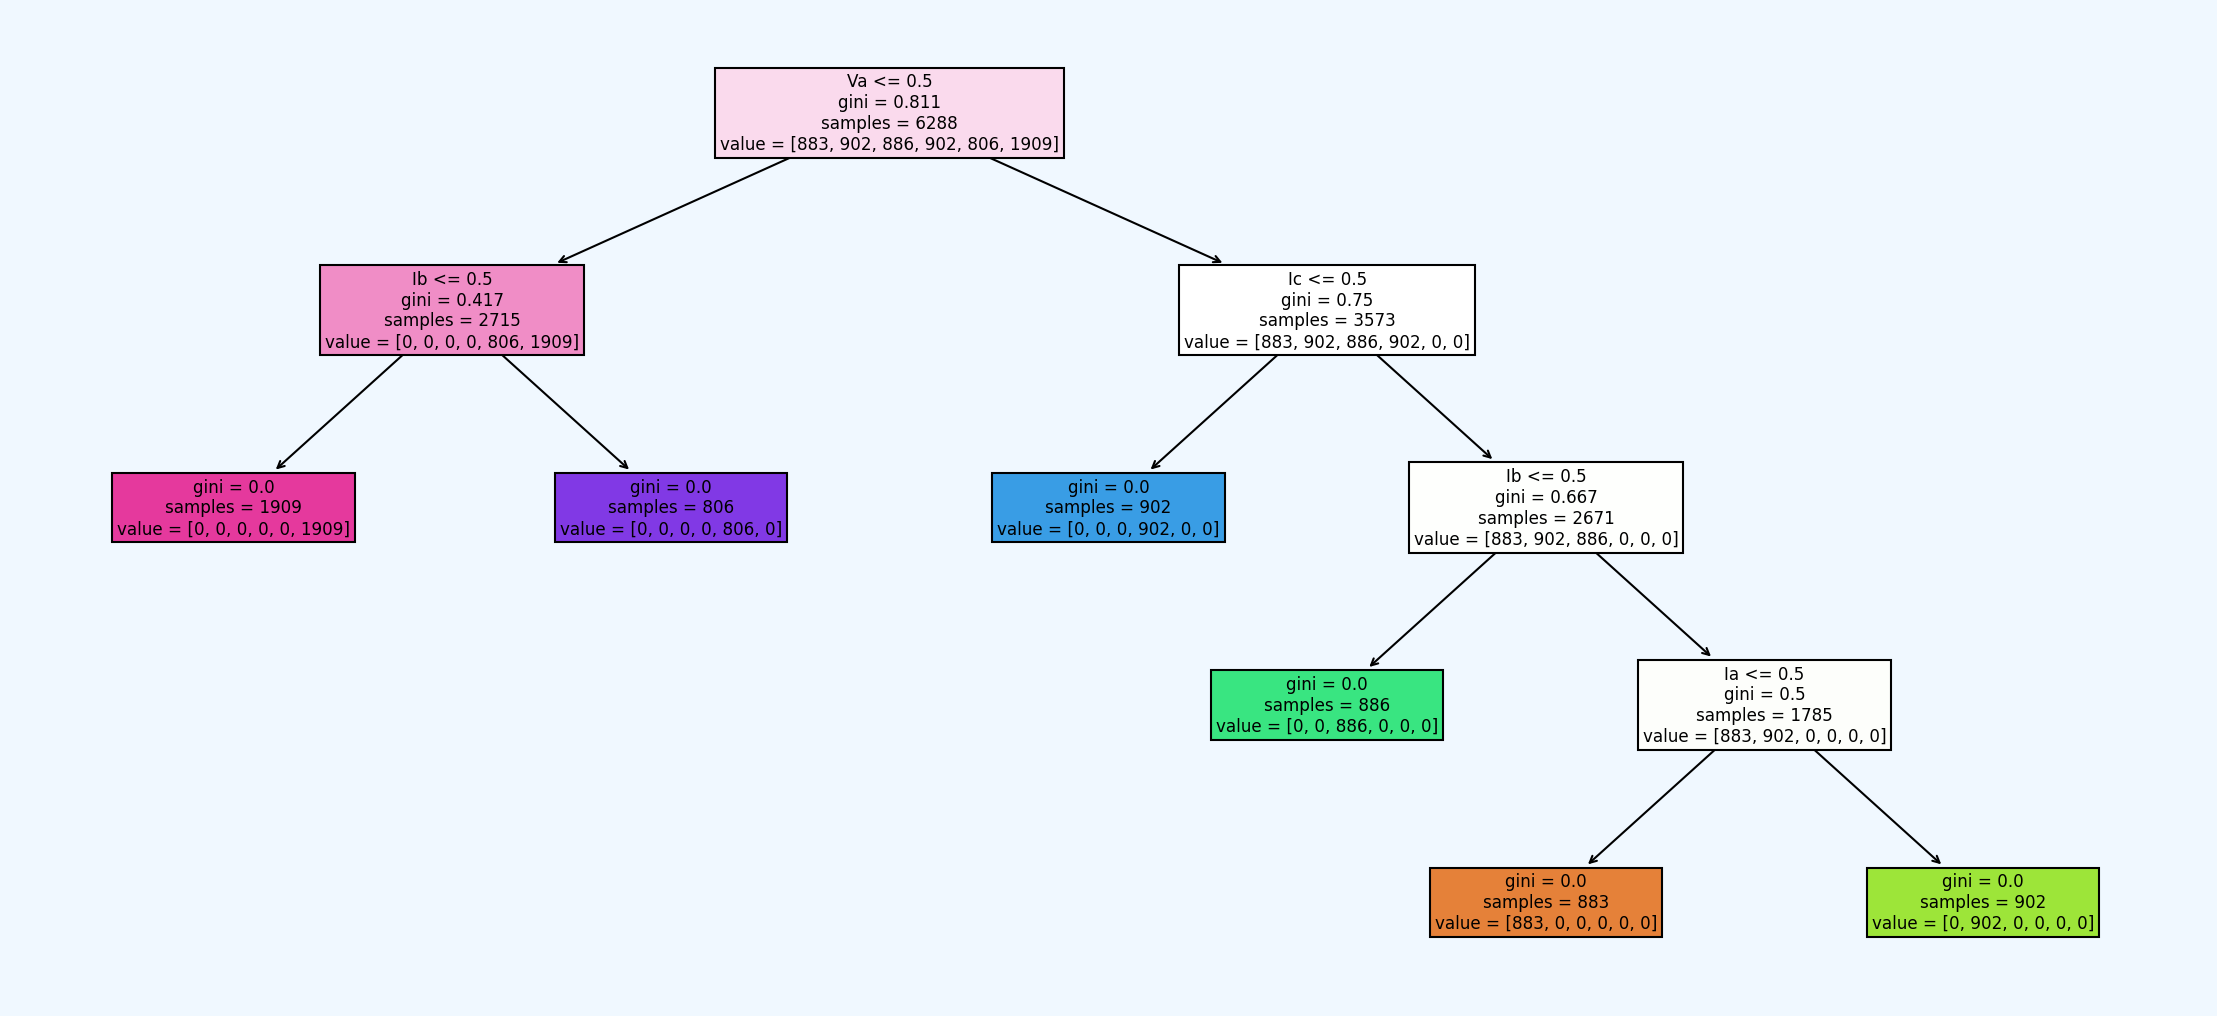

In [55]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15,7))
plot_tree(decision,filled=True,feature_names=['Ia', 'Ib', 'Ic', 'Va', 'Vb', 'Vc'])
plt.show()
